# CIS 678 - Machine Learning

## Programming Project 2 - Naive Bayes Classifier

### Julian Carrasquillo, 1/22/20


### Specification

The idea is to write a program that, when given a collection of training data consisting of labeled (`Spam` | `Ham`) text messages, “learns” how to classify (or tag) new messages correctly using a Naïve Bayes classifier. Said differently, write a spam filter.

### Background

The Naïve Bayes algorithm uses probabilities to perform classification. The probabilities are estimated based on training data for which the value of the classification is known (i.e. it is a form of Supervised Learning). The algorithm is called “naïve” because it makes the simplifying assumption that attribute values are completely independent, given the classification.

### Data set

The data consists of a collection of 5574 labeled SMS text messages in a zipped format. Format consists of 2 columns: classification and full unprocessed text message. 
  
Normally, we can use `pandas` to read in zip files directly, but this particular folder contains multiple files. We will use `zipfile` to handle.

In [2]:
from zipfile import ZipFile
import pandas as pd

with ZipFile('data/smsspamcollection.zip', 'r') as zip:
    zip.extractall(path = 'data/') 
    
sms = pd.read_table('data/SMSSpamCollection', names = ['flag', 'msg'])

sms

,flag,msg
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


We can explore the dimensions of our data set, specifically around the counts of our two classifications.

In [3]:
sms.groupby('flag').count()

,msg
flag,
ham,4825
spam,747


Most messages in our inboxes are **not** spam. This set represents the phenomenon that most of the time, the messages we receive are legitimate. It's also good to point that we have clean labels - there are no missing or mispelled indicators.
  
According to the `readme` file included with the data set, the text messages come from a few different sources. We should verify that our set consists of distinct messages.

In [4]:
sms.msg.unique

<bound method Series.unique of 0       Go until jurong point, crazy.. Available only ...
1                           Ok lar... Joking wif u oni...
2       Free entry in 2 a wkly comp to win FA Cup fina...
3       U dun say so early hor... U c already then say...
4       Nah I don't think he goes to usf, he lives aro...
                              ...                        
5567    This is the 2nd time we have tried 2 contact u...
5568                 Will ü b going to esplanade fr home?
5569    Pity, * was in mood for that. So...any other s...
5570    The guy did some bitching but I acted like i'd...
5571                           Rofl. Its true to its name
Name: msg, Length: 5572, dtype: object>

Looks like our text samples are all unique. Good to go onto text processing!  
  
## Getting our Words
  
In order to analyze the words in each text message, we need a way to extract them. It's always good to use old code when appropriate, so we can go back to [project 1](https://github.com/cis678-w20/project1-carrasq/tree/master/project_1) and use `get_words` and `clean_text`. We will need to modify the code to handle single strings as opposed to reading a file.

In [5]:
def get_words(text):
    import re
    total_words = [m.string[m.start():m.end()] for m in re.finditer("\w+(\s|\.|!|\?|,|:|;|\"|\'|\)|$)", text)]
    return total_words

def clean_text(words):
    import re
    # remove leading punctuation and capital letters for visualizations
    cleaned = []
    for word in words:
        word = re.sub("\s|\.|!|\?|,|:|;|\"|\'|\)|$", "", word)
        cleaned.append(word.lower())
    return cleaned

In [6]:
print(sms.msg[0])
get_words(sms.msg[0])

Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...


['Go ',
 'until ',
 'jurong ',
 'point,',
 'crazy.',
 'Available ',
 'only ',
 'in ',
 'bugis ',
 'n ',
 'great ',
 'world ',
 'la ',
 'e ',
 'buffet.',
 'Cine ',
 'there ',
 'got ',
 'amore ',
 'wat.']

We can build our full vocabulary by looping through all of the text messages and combining the lists into a super list. After cleaning, we will have a full collection of words to support our naive bayes classifier.

In [17]:
full_vocab = []
for msg in sms.msg:
    full_vocab = full_vocab + get_words(msg)

In [18]:
clean_text(full_vocab)[0:5]

['go', 'until', 'jurong', 'point', 'crazy']

In [19]:
vocab_clean = clean_text(full_vocab)

# remove duplicates
vocab_clean = list(set(vocab_clean))

## Training
  
Before we calculate probabilities, we need to split the data into a training and testing set. We can use a random number generator to assign the groups. To make sure the training and test group have similar ratios of `spam` to `ham` as the whole population, we will use the random generator on each group separately.

Training Set has 80.1% of the data.
Test Set has 19.9% of the data.


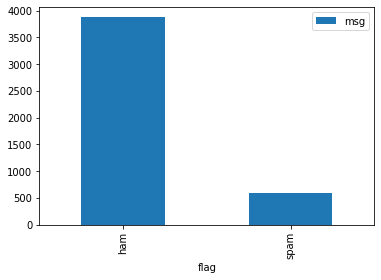

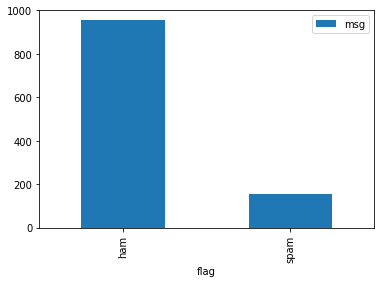

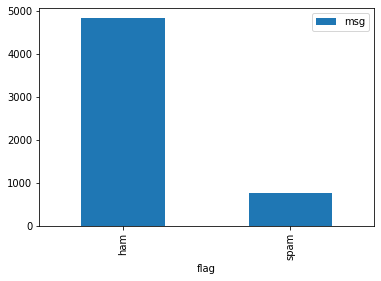

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# set seed for reproducibility
np.random.seed(42)

# split out to build properly distributed training / test sets
spam = sms[sms.flag == 'spam'].copy()
ham = sms[sms.flag == 'ham'].copy()

spam['random'] = np.random.uniform(0, 1, spam.shape[0])
ham['random'] = np.random.uniform(0, 1, ham.shape[0])

training = pd.concat([spam.loc[spam.random < 0.8], ham.loc[ham.random < 0.8]]).drop(['random'], axis = 1)
test = pd.concat([spam.loc[spam.random >= 0.8], ham.loc[ham.random >= 0.8]]).drop(['random'], axis = 1)

print("Training Set has %3.1f%% of the data." % (100*len(training)/len(sms)))
print("Test Set has %3.1f%% of the data." % (100*len(test)/len(sms)))

training.groupby('flag').count().plot(kind = 'bar')
test.groupby('flag').count().plot(kind = 'bar')
sms.groupby('flag').count().plot(kind = 'bar')

We can build a function that will calculate the various metrics needed for the classifier. For a class $c_j$, we want 

* the number of training messages in that class, $msgs_j$
* the probability estimate for a particular class,  
$P(c_j) = \frac{msgs_j}{msgs_{total}}$ 
* the total word bank from that class, $text_j$
* the number of total word tokens in $text_j$, $n$

From this, we can build out probabilities for every word $w_k$ in `full_vocab` given a specific class. For each we want

* the number of times work $w_k$ appears in $text_j$, $n_k$
* the estimate of the word occurance for a particular message type,  
$P(w_k | c_j) = \frac{n_k + 1}{n + |Vocabulary|}$
  
The added components in the probability estimate are a smoothing technique to handle any situations where a word in the test set was not found during training. Without this intervention, any message with a new word would yield a 0 probability.  
  
To count the members of a class, we can group the given table and build a dictionary. The below is a little more robust than needed, but it will be good to make this function more generalizeable. 

In [57]:
def count_classes(df, col):
    counts = df.groupby(col).count()
    counts_dict = {}
    
    for i in counts.index:
        counts_dict.update({i : counts.loc[i][0]})
    
    return counts_dict
        
count_classes(training, 'flag')

{'ham': 3872, 'spam': 592}

To get probability estimates, we can build on the `count_classes` function to also return percent of the total.

In [66]:
def count_classes(df, col):
    counts = df.groupby(col).count()
    counts_dict = {}
    # added total counter and probability dictionary
    prob_dict = {}
    total = 0
    
    for i in counts.index:
        counts_dict.update({i : counts.loc[i][0]})
        total = total + counts.loc[i][0]
    
    for i in counts.index:
        prob_dict.update({i : counts.loc[i][0] / total})
        
    return (counts_dict, prob_dict)
        
class_counts, class_probs = count_classes(training, 'flag')

To build the word bank, we use a modified version of the code used to build the full vocabulary. Specifically, we will do everything but remove the duplicates. We want to see *how often* a word appears in each class.

In [74]:
def make_wordbank(text):
    full_wordbank = []
    for msg in text:
        full_wordbank = full_wordbank + get_words(msg)
    
    return clean_text(full_wordbank)

class_wordbanks = {}
class_wordbanks_counts = {}
for group in ['ham', 'spam']:
    class_wordbanks.update({group : make_wordbank(training[training.flag == group].msg)})
    class_wordbanks_counts.update({group : len(class_wordbanks[group])})

{'ham': 56389, 'spam': 14428}

Going through our distinct total vocabulary, `vocab_clean`, we can build an embedded dictionary to show the word's prominence in each class. An embedded dictionary packages each word's probabilities for each class, allowing us to access both after a single search. This gives the dictionary a `json`-like feel.

In [86]:
vocab_classed = {}
for word in vocab_clean:
    vocab_classed.update({word : {'ham' : class_wordbanks['ham'].count(word),
                                 'spam': class_wordbanks['spam'].count(word)}})

In [85]:
# print first 5 dictionary entries
{k: vocab_classed[k] for k in list(vocab_classed)[:5]}

{'82324': {'ham': 0, 'spam': 1},
 'misplaced': {'ham': 0, 'spam': 0},
 'new': {'ham': 51, 'spam': 52},
 'onwords': {'ham': 1, 'spam': 0},
 'cos': {'ham': 50, 'spam': 0}}

Using a similar technique to the above embedded dictionary, we can build out a lookup for the conditional probabilities of a work given each class. Multiplying many probabilities together yields a smaller and smaller output with more precision needed each time to differentiate 2 words. In order to not bring in an arbitrary precision library, we can instead take the **log of each probability** and add them together to find the more likely class. 

In [99]:
import math
vocab_probs = {}
ham_length = len(class_wordbanks['ham'])
spam_length = len(class_wordbanks['spam'])
vocab_length = len(vocab_clean)

for word in vocab_clean:
    vocab_probs.update({word : {'ham' : math.log((vocab_classed[word]['ham'] + 1)/ (ham_length + vocab_length)),
                                'spam': math.log((vocab_classed[word]['spam'] + 1)/ (spam_length + vocab_length))}})

In [101]:
# print first 5 dictionary entries
{k: vocab_probs[k] for k in list(vocab_probs)[:5]}

{'82324': {'ham': -11.082157933374816, 'spam': -9.351839934249883},
 'misplaced': {'ham': -11.082157933374816, 'spam': -10.044987114809828},
 'new': {'ham': -7.130914214793389, 'spam': -6.074695201257706},
 'onwords': {'ham': -10.38901075281487, 'spam': -10.044987114809828},
 'cos': {'ham': -7.150332300650491, 'spam': -10.044987114809828}}

## Testing

Now we can take this learning and apply it to a new, never before seen data set. We set aside ~20% of our data for this purpose. A Naive Bayes classifier calculates the following for a given message:
  
$$
    C_{NB} = max_{C}(P(c_j) \Pi (P(a_i | c_j))
$$

Using the log transformation we implemented, we are interested in this iteration:

$$
    C_{NB} = max_{C}(log(P(c_j)) +  \sum_{i} log(P(a_i | c_j)))
$$

Where $a_i$ is the ith word in a message.

In [152]:
def classify_nb(text):
    import math
    ham_prob = math.log(class_probs['ham'])
    spam_prob = math.log(class_probs['spam'])
    
    for word in text:
        found_word = vocab_probs[word]
        ham_prob = ham_prob + found_word['ham']
        spam_prob = spam_prob + found_word['spam']
    
    if ham_prob > spam_prob:
        return 'ham'
    else:
        return 'spam'

In [153]:
test['pred'] = test.msg.apply(get_words).apply(clean_text).apply(classify_nb)

Because `spam` is much less common than `ham`, it is important to calculate more than just the simple accuracy estimate of $\frac{num_{correct}}{num_{total}}$. We need a confusion matrix to see how well we did within each class.

In [154]:
test.groupby(['flag', 'pred']).count().unstack()

msg     
pred  ham spam
flag          
ham   940   13
spam   13  142

Now that we have visibility to the confusion matrix, we can calculate our various evaluation metrics.

In [148]:
TP = 142
TN = 940
FP = 13
FN = 13

## Evaluate
  
It is important to note that the evaluation criteria are with respect to what we as researchers label as **positive** or **negative**. Is a true positive a correctly labeled `ham` message or is it `spam`? Based on how Python printed the confusion matrix, it looks like `ham` is the **true** label. With this in mind, it is better to think of your calculations in sentence form to get clearer insights.
  
As a baseline, we need to know the rate of `spam` and `ham` and see how a **super** naive model of "everything is ham" would do.  

In [155]:
class_probs

{'ham': 0.8673835125448028, 'spam': 0.13261648745519714}

We'd be correct about 86% correct with the training set.

*How many messages were correctly labeled?*

In [147]:
(TP + TN) / (TP + TN + FP + FN)

0.9765342960288809

*Of the `spam` messages, how many were correctly classified? (sensitivity)*

In [149]:
TP / (TP + FN)

0.9161290322580645

*Of the messages marked as `spam`, how many actually were `spam`?  (precision)*

In [150]:
TP / (TP + FP)

0.9161290322580645

*Of the `ham` messages, how many were correctly classified? (specificity)*

In [151]:
TN / (TN + FP)

0.9863588667366212

## Discussion
  
Overall, the classifier performed pretty well, with a precision and sensitivity for `spam` at close to 92%. The preprocessing steps likely had a strong influence on the performance. Removing variations in capitalization with the `.lower()` method helps to concentrate signal. Similarly, making sure there were similar proportions of `spam` in both training and test allowed the algorithm to learn in a realistic setting.  
  
We can explore the messages we incorrectly labeled. We can maybe find some insights that way.

In [159]:
test[test.flag != test.pred]

,flag,msg,pred
5,spam,FreeMsg Hey there darling it's been 3 week's n...,ham
869,spam,Hello. We need some posh birds and chaps to us...,ham
1875,spam,Would you like to see my XXX pics they are so ...,ham
2413,spam,I don't know u and u don't know me. Send CHAT ...,ham
2742,spam,I don't know u and u don't know me. Send CHAT ...,ham
2821,spam,INTERFLORA - It's not too late to order Inter...,ham
3360,spam,Sorry I missed your call let's talk when you h...,ham
3419,spam,LIFE has never been this much fun and great un...,ham
3530,spam,Xmas & New Years Eve tickets are now on sale f...,ham
3864,spam,Oh my god! I've found your number again! I'm s...,ham
